<a href="https://colab.research.google.com/github/VigneshDev16/MachineLearning_Part1/blob/main/ML_Graded_Assignment1_Vigneshwaran_COLAB_saved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Assignment 1 – IIT Mandi (IITMDDSAI 2505)
**Author:** Vigneshwaran

**Dataset:** census2011.csv
**Note:** Run this notebook in Google Colab → Upload census2011.csv when prompted.


In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_FILENAME = 'census2011.csv'
df = pd.read_csv(DATA_FILENAME)
print(df.head())

Saving census2011.csv to census2011 (2).csv
   Ranking                    District        State  Population   Growth  \
0        1                       Thane  Maharashtra  11,060,148  36.01 %   
1        2  North Twenty Four Parganas  West Bengal  10,009,781  12.04 %   
2        3                   Bangalore    Karnataka   9,621,551  47.18 %   
3        4                        Pune  Maharashtra   9,429,408  30.37 %   
4        5             Mumbai Suburban  Maharashtra   9,356,962   8.29 %   

   Sex-Ratio  Literacy  
0        886     84.53  
1        955     84.06  
2        916     87.67  
3        915     86.15  
4        860     89.91  


In [ ]:
# === 1) Preprocessing (Final Clean Version) ===

target_col = "Literacy"
candidate_features = ["Population", "Growth", "Sex-Ratio"]

working_df = df[candidate_features + [target_col]].copy()

# Clean commas & percentage signs from all numeric columns
for col in candidate_features + [target_col]:
    working_df[col] = (
        working_df[col]
        .astype(str)
        .str.replace(",", "", regex=False)   # remove commas
        .str.replace("%", "", regex=False)   # remove percent symbols
        .str.strip()                         # remove any spaces
        .replace("", np.nan)                 # blank → NaN
        .astype(float)
    )

# Drop rows with missing values
working_df = working_df.dropna()

working_df = working_df.rename(columns={target_col: "literacy"})

X = working_df[candidate_features].values
y = working_df["literacy"].values


In [ ]:
# === 1.5 Train/Validation/Test Split (re-run this) ===

np.random.seed(42)
idx = np.random.permutation(len(X))
N = len(X)

train_end = int(0.70 * N)
val_end   = train_end + int(0.15 * N)

train_idx = idx[:train_end]
val_idx   = idx[train_end:val_end]
test_idx  = idx[val_end:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


Train size: 427
Val size: 91
Test size: 92


In [ ]:
# === Standardization + Add Bias (RE-RUN this cell) ===

# Train/Val/Test split already done earlier, so reuse:
# X_train, X_val, X_test, y_train, y_val, y_test

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1.0

X_train_s = (X_train - mean) / std
X_val_s   = (X_val - mean) / std
X_test_s  = (X_test - mean) / std

def add_bias(A):
    return np.hstack([np.ones((A.shape[0], 1)), A])

X_train_b = add_bias(X_train_s)
X_val_b   = add_bias(X_val_s)
X_test_b  = add_bias(X_test_s)

print("Shapes:")
print("X_train_b:", X_train_b.shape)
print("X_val_b:", X_val_b.shape)
print("X_test_b:", X_test_b.shape)


Shapes:
X_train_b: (427, 4)
X_val_b: (91, 4)
X_test_b: (92, 4)


In [ ]:
def mse(y, y_pred): return np.mean((y - y_pred)**2)
def rmse(y, y_pred): return np.sqrt(mse(y,y_pred))
def mae(y, y_pred): return np.mean(np.abs(y - y_pred))
def r2_score(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot


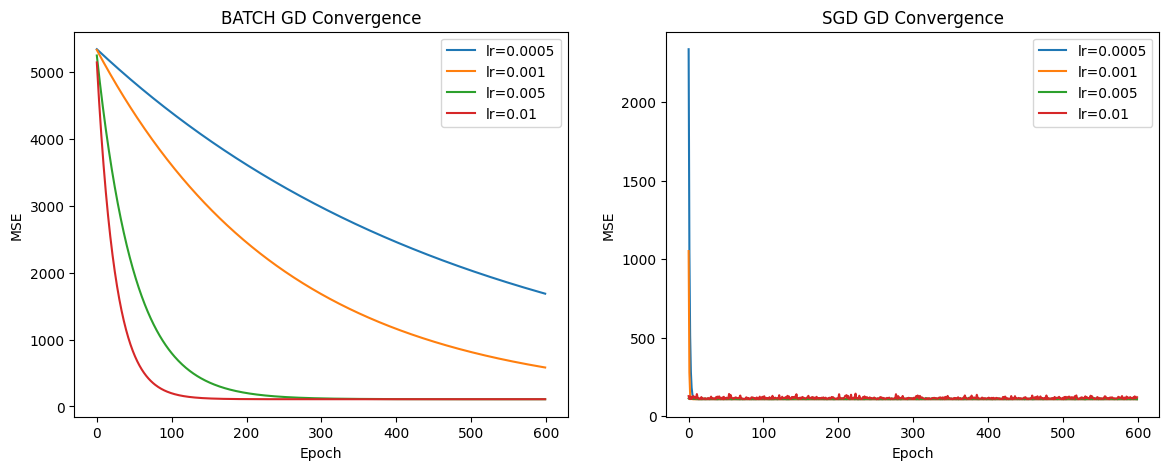

BATCH Best LR = 0.005
SGD Best LR = 0.0005


In [ ]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, epochs=600, method='batch'):
        self.lr = lr
        self.epochs = epochs
        self.method = method

    def fit(self, X, y):
        n, d = X.shape
        self.coef_ = np.zeros(d)
        self.loss_history = []
        for ep in range(self.epochs):
            if self.method == "batch":
                preds = X @ self.coef_
                grad = (2/n) * (X.T @ (preds - y))
                self.coef_ -= self.lr * grad
            else: # SGD
                for i in np.random.permutation(n):
                    xi = X[i]
                    yi = y[i]
                    pred = xi @ self.coef_
                    grad = 2*(pred-yi)*xi
                    self.coef_ -= self.lr * grad

            self.loss_history.append(mse(y, X @ self.coef_))
        return self

    def predict(self, X):
        return X @ self.coef_

learning_rates = [0.0005, 0.001, 0.005, 0.01]
models = {"batch":{}, "sgd":{}}

for method in ["batch", "sgd"]:
    for lr in learning_rates:
        m = LinearRegressionGD(lr=lr, epochs=600, method=method)
        m.fit(X_train_b, y_train)
        models[method][lr] = m

# Plot convergence
plt.figure(figsize=(14,5))
for i, method in enumerate(["batch","sgd"]):
    plt.subplot(1,2,i+1)
    for lr, m in models[method].items():
        plt.plot(m.loss_history, label=f"lr={lr}")
    plt.title(f"{method.upper()} GD Convergence")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend()
plt.savefig("figure_1.png", dpi=300, bbox_inches="tight")
plt.show()


# Pick best using validation RMSE
best_models = {}
for method in ["batch","sgd"]:
    best_lr = min(learning_rates, key=lambda lr: rmse(y_val, models[method][lr].predict(X_val_b)))
    best_models[method] = models[method][best_lr]
    print(method.upper(), "Best LR =", best_lr)



=== BATCH RESULTS ===
MSE: 91.80706853443972
RMSE: 9.581600520499679
MAE: 7.841078199280427
R²: 0.08103886596277199


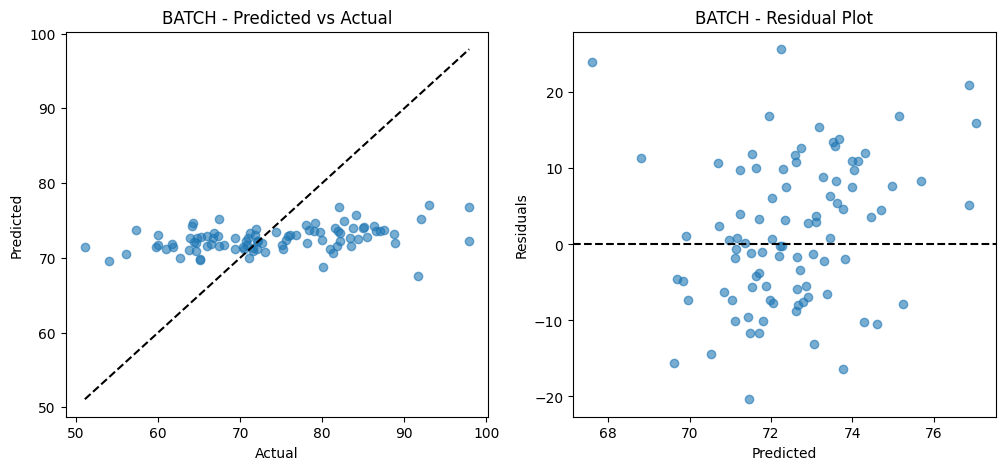


=== SGD RESULTS ===
MSE: 91.22057544605514
RMSE: 9.550946311547099
MAE: 7.833751670403854
R²: 0.0869094853193274


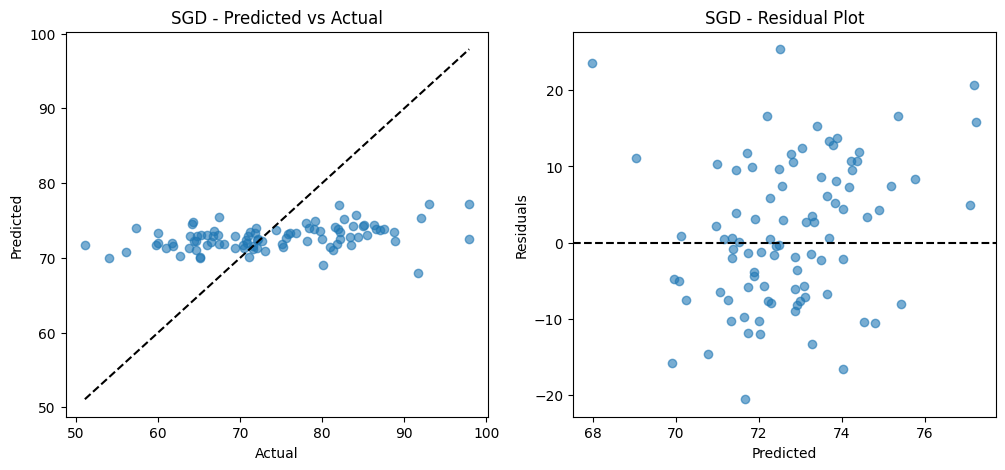

In [ ]:
for method in ["batch","sgd"]:
    model = best_models[method]
    y_pred = model.predict(X_test_b)

    print(f"\n=== {method.upper()} RESULTS ===")
    print("MSE:", mse(y_test,y_pred))
    print("RMSE:", rmse(y_test,y_pred))
    print("MAE:", mae(y_test,y_pred))
    print("R²:", r2_score(y_test,y_pred))

    # Pred vs Actual
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test,y_pred,alpha=0.6)
    mn,mx=min(y_test.min(),y_pred.min()),max(y_test.max(),y_pred.max())
    plt.plot([mn,mx],[mn,mx],'k--')
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.title(f"{method.upper()} - Predicted vs Actual")

    # Residuals
    plt.subplot(1,2,2)
    plt.scatter(y_pred, y_test-y_pred, alpha=0.6)
    plt.axhline(0,color='k',linestyle="--")
    plt.xlabel("Predicted"); plt.ylabel("Residuals")
    plt.title(f"{method.upper()} - Residual Plot")
    plt.savefig("figure_2.png", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = np.array(y)

    def predict(self, Xq):
        preds = []
        for x in Xq:
            d = np.sqrt(((self.X - x)**2).sum(axis=1))
            nn = np.argsort(d)[:self.k]
            vals, counts = np.unique(self.y[nn], return_counts=True)
            preds.append(vals[counts.argmax()])
        return np.array(preds)


In [ ]:
# Convert continuous Literacy values into class labels
labels = np.where(y < 65, "Low", np.where(y <= 85, "Medium", "High"))

# Create corresponding train / val / test labels
y_train_lbl = labels[train_idx]
y_val_lbl   = labels[val_idx]
y_test_lbl  = labels[test_idx]

print("Class distribution in Training Set:")
unique, counts = np.unique(y_train_lbl, return_counts=True)
print(dict(zip(unique, counts)))


Class distribution in Training Set:
{np.str_('High'): np.int64(49), np.str_('Low'): np.int64(101), np.str_('Medium'): np.int64(277)}


In [ ]:
ks = [3, 5, 7]
val_accs = {}

for k in ks:
    clf = KNN(k)
    clf.fit(X_train_s, y_train_lbl)
    pred_val = clf.predict(X_val_s)
    acc = (pred_val == y_val_lbl).mean()
    val_accs[k] = acc
    print(f"k={k} Val Accuracy = {acc:.4f}")

# Select best k
best_k = max(val_accs, key=val_accs.get)
print("\nBest k =", best_k)


k=3 Val Accuracy = 0.6484
k=5 Val Accuracy = 0.6593
k=7 Val Accuracy = 0.6703

Best k = 7


In [ ]:
best_clf = KNN(best_k)
best_clf.fit(X_train_s, y_train_lbl)
pred_test = best_clf.predict(X_test_s)
test_acc = (pred_test == y_test_lbl).mean()
print("\nFinal Test Accuracy =", test_acc)



Final Test Accuracy = 0.5978260869565217


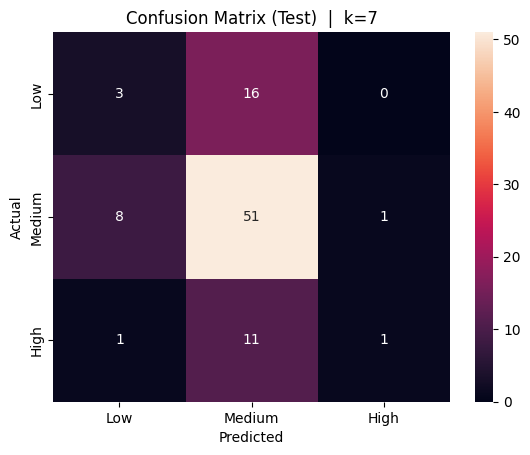

In [ ]:
def confusion_matrix_manual(y_true, y_pred, labels_order):
    idx = {c:i for i,c in enumerate(labels_order)}
    cm = np.zeros((len(labels_order), len(labels_order)), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm

labels_order = ["Low", "Medium", "High"]
cm = confusion_matrix_manual(y_test_lbl, pred_test, labels_order)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_order, yticklabels=labels_order)
plt.title(f"Confusion Matrix (Test)  |  k={best_k}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("figure_3.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from google.colab import files
import glob

for f in glob.glob("figure_*.png"):
    files.download(f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>